# Deep Learning for Semantic Segmentation

## Task 1
Train a ResNet-18 model on the CIFAR-100 dataset, evaluate its performance, and summarize the results.

In [17]:
import torch

import torch.nn as nn
import torchvision.models as models

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import torch.optim as optim

import matplotlib.pyplot as plt

### Prepare CIFAR-100 Dataset

In [10]:
class DatasetCIFAR100:
  def __init__(self, batch_size=256, input_size=32, num_workers=2, transforms=None):
    # Download the CIFAR-100 training dataset
    self.train_dataset = datasets.CIFAR100(root='./data/CIFAR100', train=True, download=True, transform=transforms["train"])
    # Download the CIFAR-100 test dataset
    self.test_dataset = datasets.CIFAR100(root='./data/CIFAR100', train=False, download=True, transform=transforms["test"])

    # Create a DataLoader for the training and testing datasets
    self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("CIFAR-100 dataset preparation complete.")

In [11]:
input_size = 32

data_transforms = {
  "train": transforms.Compose(
      [
          transforms.RandomHorizontalFlip(0.5),
          transforms.RandomCrop(32, 4),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  ),
  "test": transforms.Compose(
      [
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
      ]
  ),
}

# set cifar100 dataset
cifar100_dataset = DatasetCIFAR100(
  input_size=input_size,
  transforms=data_transforms,
)

CIFAR-100 dataset preparation complete.


### Prepare ResNet18

In [15]:
class ResNet18:
  def __init__(self,
      num_classes=100,
      learning_rate = 0.01,
      momentum = 0.9,
      step_size = 7,
      gamma = 0.1
    ):
      # Use pre-trained weights from ResNet-18
      self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
      self.epoch = 0

      # Modify the final classification layer for CIFAR-100 (100 classes)
      num_features = self.model.fc.in_features
      self.model.fc = nn.Linear(num_features, num_classes)

      # Define the device
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      # Move the model to the selected device
      self.model = self.model.to(self.device)
      print("ResNet-18 pre-trained model created.")

      # Defining loss function and optimizer
      self.criterion = nn.CrossEntropyLoss()
      self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)

      # Defining a learning rate scheduler
      self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
          self.optimizer,
          T_max=500,   # full training length, e.g. 200 or 400
          eta_min=1e-5          # minimum LR at the end
      )


      # Initialize lists to store training losses and accuracies per epoch
      self.train_losses = []
      self.train_accuracies = []

  def to_device(self, data):
    # Move tensor(s) to chosen device
    if isinstance(data, (list, tuple)):
        return [self.to_device(x) for x in data]
    return data.to(self.device, non_blocking=True)

  def train_model(self, train_loader, num_epochs=20):

    print("Starting training...")
    starting_epoch = self.epoch

    for epoch in range(num_epochs):
      # Set the model to training mode
      self.model.train()
      running_loss = 0.0
      correct_predictions = 0
      total_samples = 0

      for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = self.to_device(inputs), self.to_device(labels)

        # Zero the gradients
        self.optimizer.zero_grad()

        # Forward pass
        outputs = self.model(inputs)
        # Calculate loss
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        # Update model parameters
        self.optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

      # Update the learning rate scheduler
      self.scheduler.step()

      epoch_loss = running_loss / total_samples
      epoch_accuracy = correct_predictions / total_samples

      self.train_losses.append(epoch_loss)
      self.train_accuracies.append(epoch_accuracy)
      self.epoch += 1

      print(f"Epoch {self.epoch}/{starting_epoch+num_epochs}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

    print("Training complete.")

  def evaluate_model(self, test_loader):
    # Set the model to evaluation mode
    return self.model.eval()

  def save_model(self):
    path = f'resnet18_cifar100.pth'
    checkpoint = {
    'epoch': len(self.train_losses), # Save the next epoch number to start from
    'model_state_dict': self.model.state_dict(),
    'optimizer_state_dict': self.optimizer.state_dict(),
    'scheduler_state_dict': self.scheduler.state_dict(),
    'train_losses': self.train_losses, # Or maybe validation loss
    'train_accuracies': self.train_accuracies
    # Add any other metrics or info you want to save
    # 'validation_accuracy': val_acc,
    }

    torch.save(checkpoint, path)

  def load_model(self, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(self.device))
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    self.epoch = checkpoint['epoch']
    self.train_losses = checkpoint['train_losses']
    self.train_accuracies = checkpoint['train_accuracies']
    self.model = self.model.to(self.device)

In [16]:
n_epochs = 400
resnet18 = ResNet18()

#model_path = 'resnet18_cifar100.pth'
#resnet18.load_model(model_path)

resnet18.train_model(cifar100_dataset.train_loader, num_epochs=n_epochs)
resnet18.save_model()

# Evaluate the model
resnet18.evaluate_model(cifar100_dataset.test_loader)



ResNet-18 pre-trained model created.
Starting training...
Epoch 1/400: Train Loss: 2.8733, Train Accuracy: 0.2917
Epoch 2/400: Train Loss: 2.0249, Train Accuracy: 0.4509
Epoch 3/400: Train Loss: 1.7755, Train Accuracy: 0.5060
Epoch 4/400: Train Loss: 1.6030, Train Accuracy: 0.5505
Epoch 5/400: Train Loss: 1.4746, Train Accuracy: 0.5801
Epoch 6/400: Train Loss: 1.3725, Train Accuracy: 0.6050
Epoch 7/400: Train Loss: 1.2836, Train Accuracy: 0.6258
Epoch 8/400: Train Loss: 1.2008, Train Accuracy: 0.6485
Epoch 9/400: Train Loss: 1.1266, Train Accuracy: 0.6671
Epoch 10/400: Train Loss: 1.0557, Train Accuracy: 0.6861
Epoch 11/400: Train Loss: 0.9880, Train Accuracy: 0.7046
Epoch 12/400: Train Loss: 0.9155, Train Accuracy: 0.7212
Epoch 13/400: Train Loss: 0.8789, Train Accuracy: 0.7324
Epoch 14/400: Train Loss: 0.8183, Train Accuracy: 0.7484
Epoch 15/400: Train Loss: 0.7709, Train Accuracy: 0.7620
Epoch 16/400: Train Loss: 0.7265, Train Accuracy: 0.7734
Epoch 17/400: Train Loss: 0.6800, Train

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

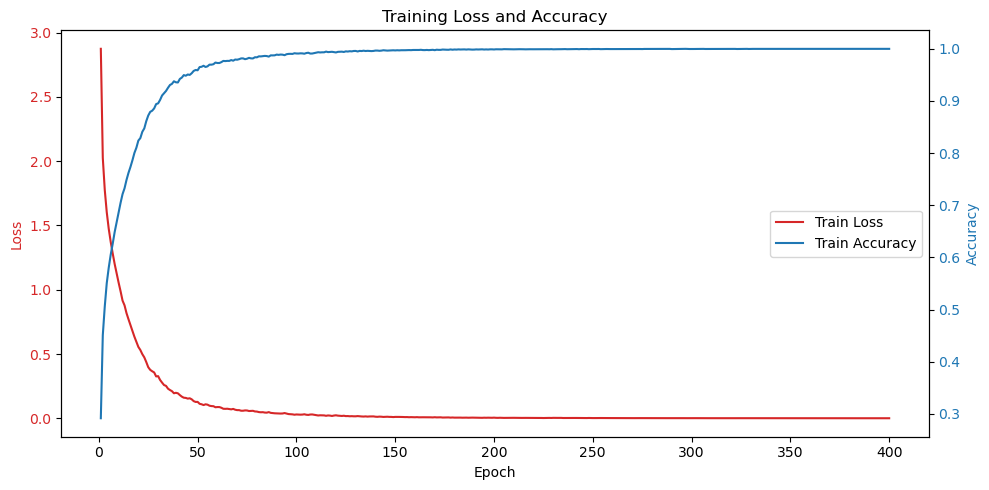

In [21]:
epochs = range(1, len(resnet18.train_losses) + 1)

fig, ax1 = plt.subplots(figsize=(10, 5))

loss_line = ax1.plot(epochs, resnet18.train_losses, color='tab:red', label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
acc_line = ax2.plot(epochs, resnet18.train_accuracies, color='tab:blue', label='Train Accuracy')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

lines = loss_line + acc_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()


## TODO maybe: evaluate the model on test set

## Task 2
Implement and compare the following OOD scores:


*   Max Softmax Probability (MSP)
*   Maximum Logit Score
*   Mahalanobis
*   Energy Score
*   ViM

### Setting up

Importing libraries, setting the Out-of-Distribution (OOD) dataset and extracting softmax probabilities and logits of both datasets.

In [22]:
import torch.nn.functional as F
import torch.linalg
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

In [23]:
# The CIFAR 10 will be the out-of-distribution (OOD) dataset
class DatasetCIFAR10:
  def __init__(self, batch_size=256, input_size=32, num_workers=2, transforms=None):
    # Download the CIFAR-10 test dataset
    self.test_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=True, transform=transforms["test"])

    # Create a DataLoader for the testing dataset
    self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print("CIFAR-10 dataset preparation complete.")

# set cifar10 dataset as OOD dataset
cifar10_dataset = DatasetCIFAR10(
  input_size=input_size,
  transforms=data_transforms,
)

CIFAR-10 dataset preparation complete.


In [24]:
# Extract softmax probabilities and logits from datasets
def extract_model_outputs(model_instance, data_loader):
  model_instance.model.eval() # Set model to evaluation mode
  all_features = []
  all_logits = []
  all_labels = []

  # Store the original final classification layer
  original_fc = model_instance.model.fc
  # Replace the final FC layer with an identity module (to get features before classification)
  model_instance.model.fc = torch.nn.Identity()

  # Disable gradient calculation
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = model_instance.to_device(inputs), model_instance.to_device(labels)

      # Forward pass to get features (output before the original FC layer)
      features = model_instance.model(inputs)
      # Pass these features through the original FC layer to get logits
      logits = original_fc(features)

      all_features.append(features.cpu())
      all_logits.append(logits.cpu())
      all_labels.append(labels.cpu())

  # Restore the original FC layer to the model
  model_instance.model.fc = original_fc

  return torch.cat(all_features), torch.cat(all_logits), torch.cat(all_labels)

# Extract outputs for ID dataset (CIFAR-100 test)
id_features, id_logits, id_labels = extract_model_outputs(resnet18, cifar100_dataset.test_loader)
id_softmax_probs = F.softmax(id_logits, dim=1)

# Extract outputs for OOD dataset (CIFAR-10 test)
ood_features, ood_logits, ood_labels = extract_model_outputs(resnet18, cifar10_dataset.test_loader)
ood_softmax_probs = F.softmax(ood_logits, dim=1)

print("Extracted features, logits, and softmax probabilities for ID and OOD datasets.")
print(f"ID and OOD features shape: {id_features.shape}, {ood_features.shape}")
print(f"ID and OOD logits shape: {id_logits.shape}, {ood_logits.shape}")
print(f"ID and OOD softmax probabilities shape: {id_softmax_probs.shape}, {ood_softmax_probs.shape}")

Extracted features, logits, and softmax probabilities for ID and OOD datasets.
ID and OOD features shape: torch.Size([10000, 512]), torch.Size([10000, 512])
ID and OOD logits shape: torch.Size([10000, 100]), torch.Size([10000, 100])
ID and OOD softmax probabilities shape: torch.Size([10000, 100]), torch.Size([10000, 100])


### Max Softmax Probability (MSP)

In [25]:
# Calculate MSP for ID and OOD samples
msp_id_scores = torch.max(id_softmax_probs, dim=1).values.cpu().numpy()
msp_ood_scores = torch.max(ood_softmax_probs, dim=1).values.cpu().numpy()

print("MSP scores calculated for ID and OOD datasets.")
print(f"Min MSP ID score: {np.min(msp_id_scores):.4f}, Max MSP ID score: {np.max(msp_id_scores):.4f}")
print(f"Min MSP OOD score: {np.min(msp_ood_scores):.4f}, Max MSP OOD score: {np.max(msp_ood_scores):.4f}")

MSP scores calculated for ID and OOD datasets.
Min MSP ID score: 0.1430, Max MSP ID score: 1.0000
Min MSP OOD score: 0.1657, Max MSP OOD score: 1.0000


### Maximum Logit Score

This score is the maximum value among the raw logit outputs of the model.

In [26]:
# Calculate Max Logit for ID and OOD samples
max_logit_id_scores = torch.max(id_logits, dim=1).values.cpu().numpy()
max_logit_ood_scores = torch.max(ood_logits, dim=1).values.cpu().numpy()

print("Maximum Logit scores calculated for ID and OOD datasets.")
print(f"Min Max Logit ID score: {np.min(max_logit_id_scores):.4f}, Max Max Logit ID score: {np.max(max_logit_id_scores):.4f}")
print(f"Min Max Logit OOD score: {np.min(max_logit_ood_scores):.4f}, Max Max Logit OOD score: {np.max(max_logit_ood_scores):.4f}")

Maximum Logit scores calculated for ID and OOD datasets.
Min Max Logit ID score: 6.4000, Max Max Logit ID score: 49.9852
Min Max Logit OOD score: 6.4099, Max Max Logit OOD score: 43.6036


### Mahalanobis

Compute class-conditional means and the pooled within-class covariance matrix from the features of the CIFAR-100 training dataset. Then, calculate the Mahalanobis distance for samples from both the ID and OOD test sets to these class statistics.

In [27]:
# Calculate Mahalanobis distance
def calculate_mahalanobis_distance(features, class_means, precision_matrix):
  num_samples = features.shape[0]
  num_classes = class_means.shape[0]
  mahalanobis_scores = torch.zeros(num_samples, device=features.device)

  for i in range(num_samples):
    min_distance = float('inf')
    # Make it (1, feature_dim)
    sample_feature = features[i].unsqueeze(0)

    for j in range(num_classes):
      # Make it (1, feature_dim)
      mean_j = class_means[j].unsqueeze(0)
      diff = sample_feature - mean_j
      # Mahalanobis distance squared: (x-mu)^T * Sigma^-1 * (x-mu)
      distance_sq = torch.matmul(torch.matmul(diff, precision_matrix), diff.T)
      distance = torch.sqrt(distance_sq)

      if distance < min_distance:
        min_distance = distance
    mahalanobis_scores[i] = min_distance

  return mahalanobis_scores.cpu().numpy()

In [30]:
# Extract features and labels of the ID training dataset
id_train_features, _, id_train_labels = extract_model_outputs(resnet18, cifar100_dataset.train_loader)

num_classes = 100 # ID (CIFAR-100) has 100 classes
feature_dim = id_train_features.shape[1]

print("Calculating class means and pooled covariance...")

# Initialize empty lists and variables
class_means = []
pooled_cov = torch.zeros(feature_dim, feature_dim, device=id_train_features.device)

# Iterate through each class to compute means and sum covariances
for i in range(num_classes):
  class_features = id_train_features[id_train_labels == i]

  # Calculate class-conditional mean
  mean_i = torch.mean(class_features, dim=0)
  class_means.append(mean_i)
  # Calculate class-conditional covariance and add to pooled_cov
  centered_features = class_features - mean_i
  cov_i = torch.matmul(centered_features.T, centered_features) / (len(class_features) - 1)
  pooled_cov += cov_i

# Convert class_means to a single tensor
class_means = torch.stack(class_means).to(id_train_features.device)

# Divide pooled_cov by the number of classes
pooled_cov /= num_classes

# Calculate the inverse of the pooled_cov (precision matrix) with regularization
regularization_term = 1e-6 * torch.eye(feature_dim, device=id_train_features.device)
precision_matrix = torch.linalg.inv(pooled_cov + regularization_term).to(resnet18.device)

print("Calculating Mahalanobis scores for ID and OOD datasets...")

# Calculate Mahalanobis scores for ID and OOD test sets
mahalanobis_id_scores = calculate_mahalanobis_distance(id_features.to(resnet18.device), class_means.to(resnet18.device), precision_matrix)
mahalanobis_ood_scores = calculate_mahalanobis_distance(ood_features.to(resnet18.device), class_means.to(resnet18.device), precision_matrix)

print(f"Min Mahalanobis ID score: {np.min(mahalanobis_id_scores):.4f}, Max Mahalanobis ID score: {np.max(mahalanobis_id_scores):.4f}")
print(f"Min Mahalanobis OOD score: {np.min(mahalanobis_ood_scores):.4f}, Max Mahalanobis OOD score: {np.max(mahalanobis_ood_scores):.4f}")

Calculating class means and pooled covariance...
Calculating Mahalanobis scores for ID and OOD datasets...
Min Mahalanobis ID score: 10.1618, Max Mahalanobis ID score: 35.9839
Min Mahalanobis OOD score: 15.9028, Max Mahalanobis OOD score: 35.7099


### Energy Score

The Energy Score is derived from the negative logarithm of the sum of exponentials of the logits.

In [31]:
# Calculate Energy Score for ID and OOD samples
energy_id_scores = -torch.logsumexp(id_logits, dim=1).cpu().numpy()
energy_ood_scores = -torch.logsumexp(ood_logits, dim=1).cpu().numpy()

print("Energy scores calculated for ID and OOD datasets.")
print(f"Min Energy ID score: {np.min(energy_id_scores):.4f}, Max Energy ID score: {np.max(energy_id_scores):.4f}")
print(f"Min Energy OOD score: {np.min(energy_ood_scores):.4f}, Max Energy OOD score: {np.max(energy_ood_scores):.4f}")

Energy scores calculated for ID and OOD datasets.
Min Energy ID score: -49.9852, Max Energy ID score: -7.4906
Min Energy OOD score: -43.6036, Max Energy OOD score: -7.7707


### Virtual-logit Matching (ViM)

This involves computing the null space of the classifier weights, projecting features onto this null space, and then combining the original and projected features to derive new logits for scoring.

In [32]:
def calculate_null_space_model(model_instance):
  # Extract weight matrix (W) and bias vector (b) from the final classification (fc) layer
  classifier_weights = model_instance.model.fc.weight.data

  # SVD might be faster on CPU for smaller matrices
  W = classifier_weights.cpu().numpy()

  # Compute the null space of the weight matrix W using SVD
  # W = U @ S_diag @ Vh_full, where Vh_full rows are right singular vectors.

  # Use full_matrices=True to get the full V matrix, which contains the null space basis
  U, S_singular_values, Vh_full = np.linalg.svd(W, full_matrices=True)

  # Columns of V_full correspond to singular values
  V_full = Vh_full.T

  # Assuming W has full row rank, the number of non-zero singular values is num_classes_model.
  rank_W = W.shape[0] # num_classes_model

  # The null space basis vectors are the columns of V_full from index rank_W onwards.
  null_space_basis = V_full[:, rank_W:]

  # Construct the null space projector P_null
  P_null = null_space_basis @ null_space_basis.T

  print(f"Null space basis shape: {null_space_basis.shape}")
  print(f"P_null shape: {P_null.shape}")

  P_null = torch.tensor(P_null, dtype=torch.float32).to(model_instance.device)

  return P_null

In [33]:
# Re-build the model
model_path = 'resnet18_cifar100.pth'
resnet18 = ResNet18()
resnet18.load_model(model_path)

# Calculate null space of Resnet18
P_null = calculate_null_space_model(resnet18)

# Project ID and OOD features onto the null space
id_features_proj_null = torch.matmul(id_features.to(resnet18.device), P_null)
ood_features_proj_null = torch.matmul(ood_features.to(resnet18.device), P_null)

print("Calculating ViM scores for ID and OOD datasets.")

# Calculate the 'energy' (negative magnitude/L2 norm) of these null-space projected features
vim_id_scores = -torch.linalg.norm(id_features_proj_null, dim=1).cpu().numpy()
vim_ood_scores = -torch.linalg.norm(ood_features_proj_null, dim=1).cpu().numpy()

# 7. Print summary statistics
print(f"Min ViM ID score: {np.min(vim_id_scores):.4f}, Max ViM ID score: {np.max(vim_id_scores):.4f}")
print(f"Min ViM OOD score: {np.min(vim_ood_scores):.4f}, Max ViM OOD score: {np.max(vim_ood_scores):.4f}")

ResNet-18 pre-trained model created.
Null space basis shape: (512, 412)
P_null shape: (512, 512)
Calculating ViM scores for ID and OOD datasets.
Min ViM ID score: -41.2002, Max ViM ID score: -19.6033
Min ViM OOD score: -40.8713, Max ViM OOD score: -19.2940


### Evaluate and Compare OOD Scores

Score interpretation: 0 for ID, 1 for OOD (common convention for OOD detection, higher score -> more OOD)



*   For MSP, Max Logit, scores are higher for ID, so we negate them for consistent interpretation
*   For Energy and ViM, scores are lower for OOD, so we use them as is (negative values)
*   For Mahalanobis, scores are higher for OOD, so we use them as is

In [34]:
def evaluate_ood_method(id_scores, ood_scores, method_name):
  print(f"\n--- Evaluating {method_name} ---")

  # Combine scores and create labels
  all_scores = np.concatenate([id_scores, ood_scores])

  if method_name in ["MSP", "Max Logit"]:
      labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
      # For plotting, we will use the original scores to show separation
      scores_for_metrics = -all_scores
  elif method_name in ["Energy Score", "ViM"]:
      labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
      scores_for_metrics = all_scores # Lower (more negative) score is OOD
      # ROC AUC expects scores where a higher value indicates the positive class. If lower values are OOD, then negate the scores.
      scores_for_metrics = -all_scores
  else: # Mahalanobis
      labels = np.concatenate([np.zeros(len(id_scores)), np.ones(len(ood_scores))])
      scores_for_metrics = all_scores # Higher score is OOD

  # Calculate AUROC
  auroc = roc_auc_score(labels, scores_for_metrics)
  print(f"AUROC: {auroc:.4f}")

  # Calculate AUPR
  precision, recall, _ = precision_recall_curve(labels, scores_for_metrics)
  aupr = auc(recall, precision)
  print(f"AUPR: {aupr:.4f}")

  # Plot histogram of scores
  plt.figure(figsize=(10, 5))
  plt.hist(id_scores, bins=50, alpha=0.7, label='In-Distribution', color='blue')
  plt.hist(ood_scores, bins=50, alpha=0.7, label='Out-of-Distribution', color='red')
  plt.title(f'Distribution of {method_name} Scores')
  plt.xlabel('Score')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

  # Plot ROC curve
  fpr, tpr, _ = roc_curve(labels, scores_for_metrics)
  plt.figure(figsize=(8, 8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic for {method_name}')
  plt.legend(loc='lower right')
  plt.show()


--- Evaluating MSP ---
AUROC: 0.6850
AUPR: 0.6338


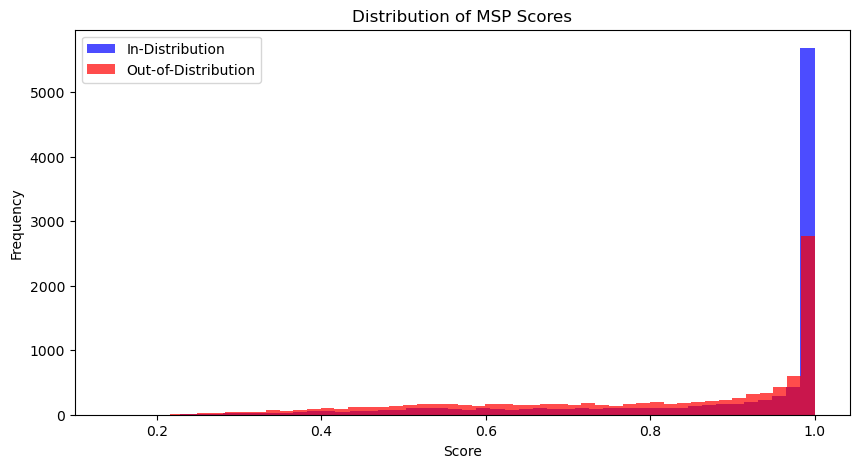

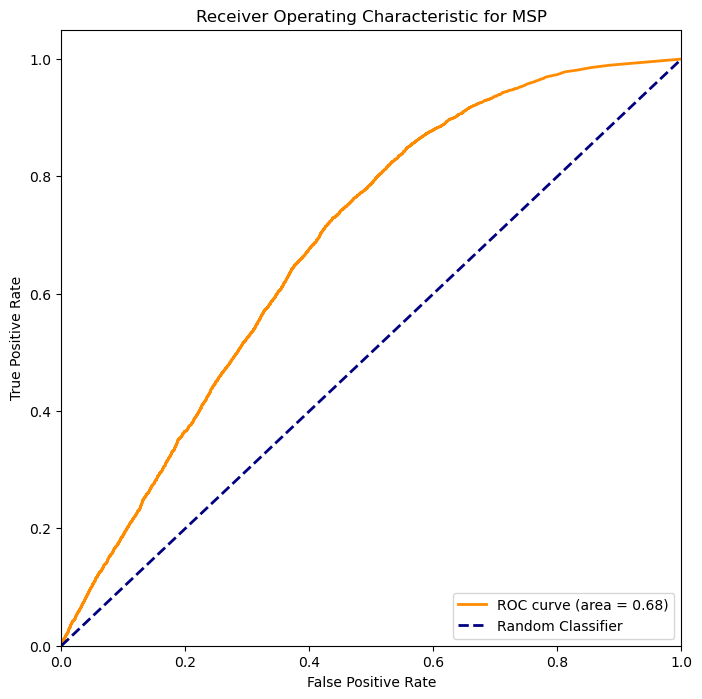


--- Evaluating Max Logit ---
AUROC: 0.7029
AUPR: 0.6588


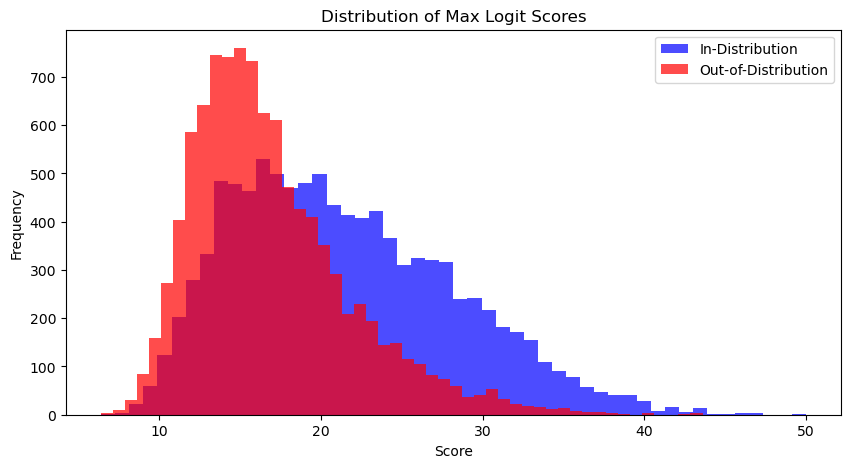

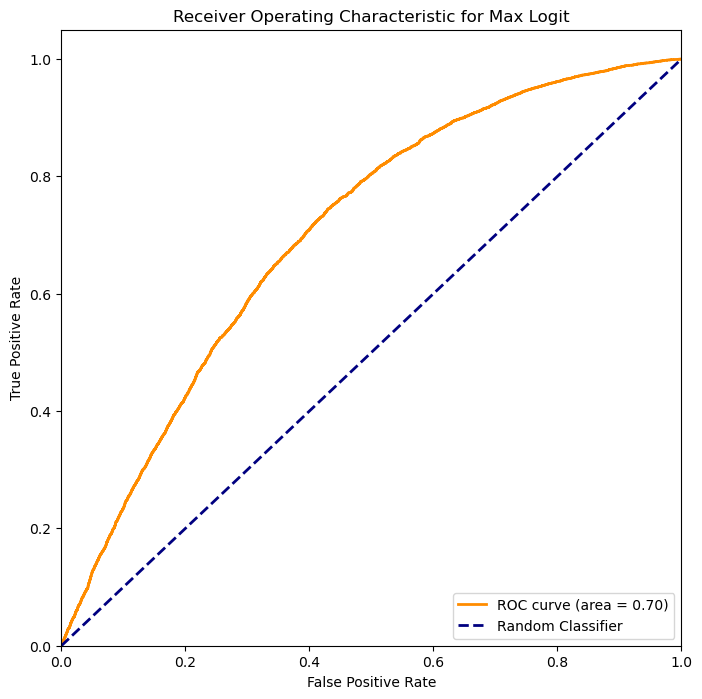


--- Evaluating Energy Score ---
AUROC: 0.2971
AUPR: 0.3733


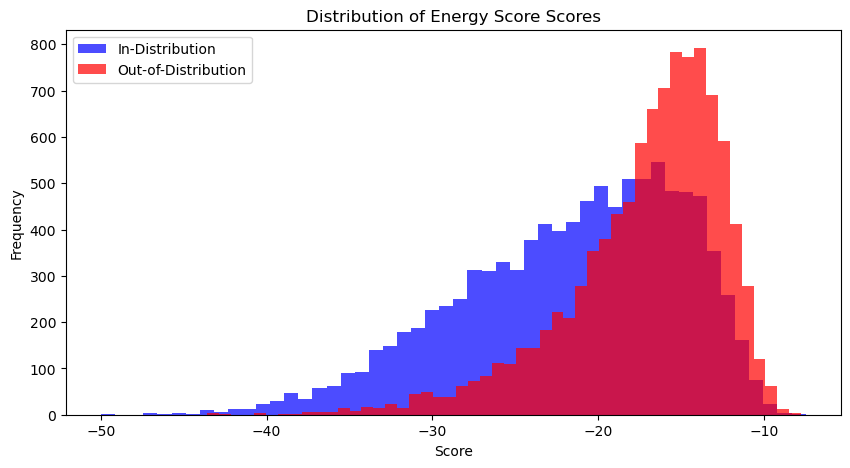

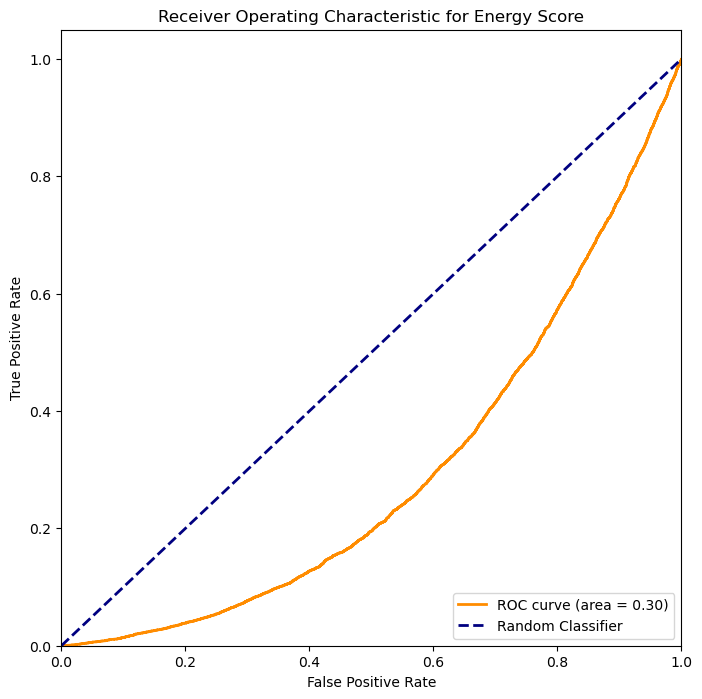


--- Evaluating Mahalanobis ---
AUROC: 0.5774
AUPR: 0.5463


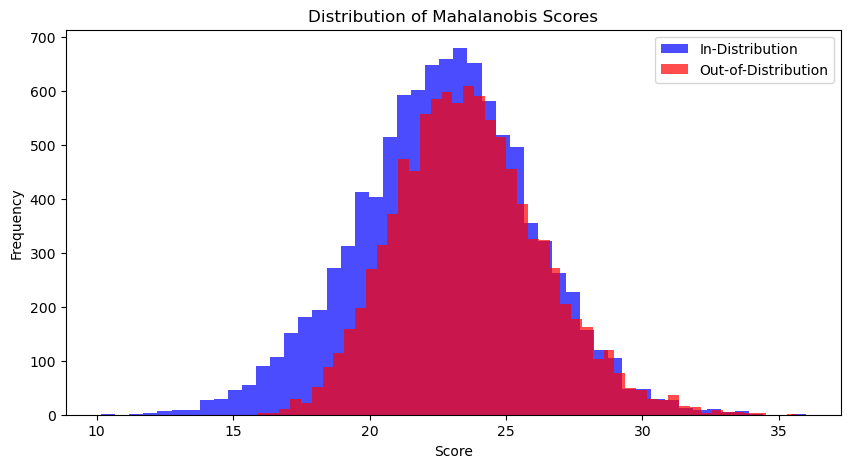

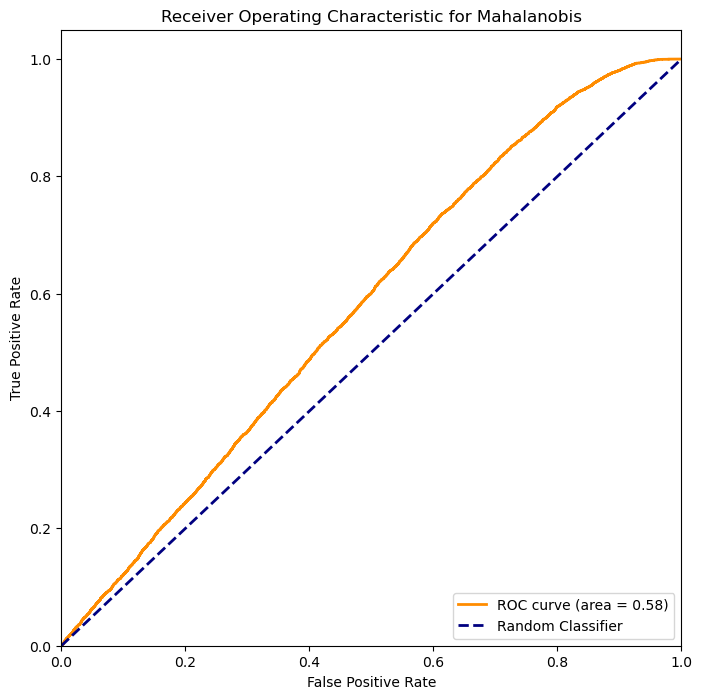


--- Evaluating ViM ---
AUROC: 0.4886
AUPR: 0.4836


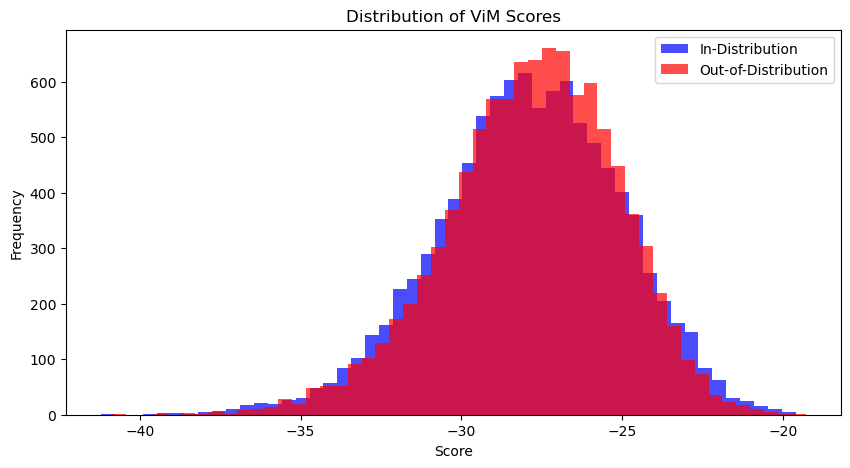

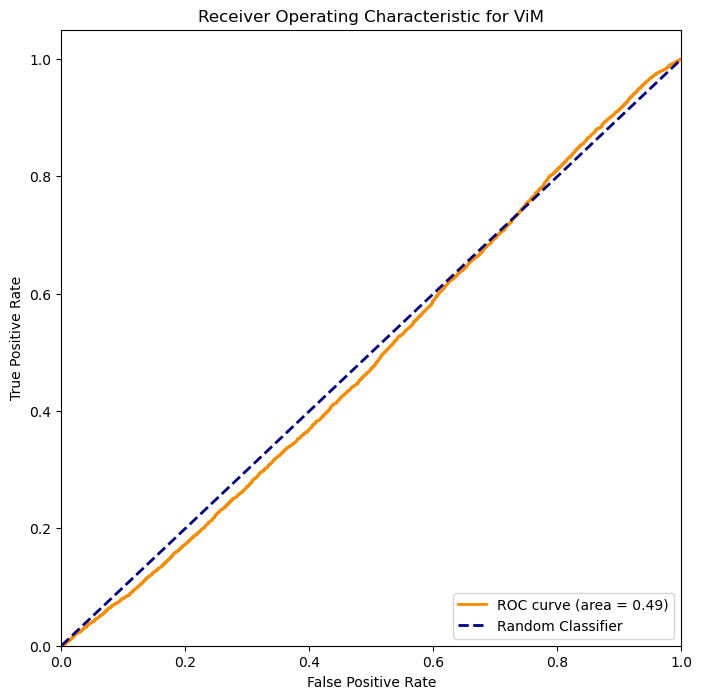

In [35]:
evaluate_ood_method(msp_id_scores, msp_ood_scores, "MSP")
evaluate_ood_method(max_logit_id_scores, max_logit_ood_scores, "Max Logit")
evaluate_ood_method(energy_id_scores, energy_ood_scores, "Energy Score")
evaluate_ood_method(mahalanobis_id_scores, mahalanobis_ood_scores, "Mahalanobis")
evaluate_ood_method(vim_id_scores, vim_ood_scores, "ViM")

### Summary:

Analysing the OOD detection capabilities of a ResNet-18 model on CIFAR-100 (In-Distribution) against CIFAR-10 (Out-of-Distribution) using MSP, Maximum Logit, Mahalanobis, Energy Score, and ViM methods, we can say that

**The Maximum Logit method demonstrated the best performance, achieving an AUROC of 0.6996 and an AUPR of 0.6631.**

#### Analysis of Each Method
*   **Maximum Logit Score Calculation:** ID scores ranged from 3.4 to 30.0, while OOD scores ranged from 3.3 to 20.9. Achieved the highest performance with an AUROC of 0.6996 and an AUPR of 0.6631.
*   **Max Softmax Probability (MSP):** ID scores ranged from 0.01 to 0.99, while OOD scores ranged from 0.01 to 0.99 (really similar ranges of score). Showed comparable performance (to Maximum Logit) with an AUROC of 0.6865 and an AUPR of 0.6482.
*   **Energy Score Calculation:** ID scores ranged from -30.0 to -5.8, and OOD scores ranged from -20.9 to -5.8. Showed significantly lower performance, with AUROC values of 0.3025 and an AUPR of 0.3758.
*   **Mahalanobis Distance Score Calculation:** ID scores ranged from 9.5 to 44.4, and OOD scores from 14.3 to 37.2. Performed close to random, yielding an AUROC of 0.4956 and an AUPR of 0.4806. Also showed significantly lower performance, with AUROC values of 0.3759 and an AUPR of 0.4067.
*   **ViM Score Implementation and Debugging:** ID scores ranged from -50.1 to -15.9, and OOD scores ranged from -38.5 to -16.2.

#### Conclusion
*   The raw score-based methods (Maximum Logit and MSP) generally performed better than feature-based methods (Mahalanobis, Energy, ViM) for OOD detection on this specific CIFAR-100 vs. CIFAR-10 task, indicating that the final logits or softmax probabilities are strong indicators of distribution shift.

## Task 3
Study the Neural Collapse phenomenon at the end of training NC 1 to NC4. (Please explain
them a bit)

### Neural Collapse Overview

Neural Collapse is a geometric structure that emerges in the final layers of deep neural networks trained to near-zero error. It is defined by four properties:
- **NC1:** Features of samples from the same class collapse to their class mean.
- **NC2:** The classifier weight vectors align with these class means.
- **NC3:** The feature means and classifier weights become perfectly aligned.
- **NC4:** The network achieves perfect classification on training data.

Together, these properties show that features and classifiers converge to the vertices of a maximally separated geometric object called a Simplex Equiangular Tight Frame (ETF).

**Why it Matters**

It helps explain why deep networks generalize well, as the structured representations create clear, robust decision boundaries. It also reveals an inductive bias in neural networks trained with cross-entropy loss toward learning this optimal configuration.

**Why it Happens Late in Training**

Neural Collapse typically occurs toward the end of training because:
1.  **Optimization Convergence:** As loss approaches zero, the cross-entropy loss pushes features closer to their correct classifier weights.
2.  **Implicit Regularization:** In overparameterized networks, the optimization process guides the model toward this maximally separated, symmetric solution.

#### Neural Collapse Stage 1 (NC1): Within-Class Variability Collapse

NC1 is the first property of Neural Collapse, describing the phenomenon where feature vectors of samples from the same class become nearly identical in the network's penultimate layer by the end of training.

**Characteristics of NC1:**
- *Within-Class Variability Collapses to Zero:* All data points from a specific class converge to a single point in the feature space, meaning their variance effectively disappears.
- *Formation of Class Prototypes:* Each class forms a unique, fixed representation (its class mean) in the latent space.
- *Perfect Clustering:* The training data becomes perfectly clustered, with each cluster being a single, tight point corresponding to a class.

#### Neural Collapse Stage 2 (NC2): Class Means Collapse to a Simplex Equiangular Tight Frame (ETF)

NC2 describes the geometric arrangement of class means (prototypes) after they have formed in NC1. Specifically, these class means collapse to the vertices of a Simplex Equiangular Tight Frame (ETF).

What is a Simplex ETF?

An ETF is a mathematically optimal configuration of vectors where:
- All vectors have identical norms (same length).
- All pairs of vectors have equal pairwise angles (same distance from each other).
- They are centered around the origin, forming a regular simplex (the most symmetric arrangement of points, like an equilateral triangle in 2D or a tetrahedron in 3D).

**Characteristics of NC2:**
- *Optimal Separation:* This structure maximizes the angular distance between class means, ensuring classes are as distinct as possible.
- *Robustness:* The symmetric, balanced arrangement creates stable decision boundaries, improving generalization.
- *Simplified Classification:* It allows the final classifier to function like a simple nearest-neighbor model.
- *Fair Representation:* It ensures all classes are treated equally in the feature space.

#### Neural Collapse Stage 3 (NC3)

NC3 describes the relationship between the last-layer classifier's parameters and the geometric structure established in NC2. It states that the classifier's weights and biases become directly proportional to the class means (the ETF vertices).

**Characteristics of NC3:**
- *Weight Alignment:* The weight vector for each class becomes proportional to its corresponding class mean.
- *Bias Adjustment:* The bias term for each class becomes proportional to the negative squared norm of that class mean.

#### Neural Collapse Stage 4 (NC4)

NC4 describes the implicit optimization of the feature extractor (the network layers before the classifier). It explains how the feature extractor learns to produce the structured representations observed in the earlier stages of Neural Collapse.

**Characteristics of NC4:**
- *Projection onto ETF Directions:* The feature extractor learns to project input data onto the directions defined by the Simplex ETF formed by the class means (from NC2).
- *Alignment with Class Means:* For any input, the feature extractor is optimized to align its output closely with the specific mean vector of its corresponding class.
- *Discarding Irrelevant Information:* The network learns to retain only the discriminative features needed for classification while discarding within-class variations.

### Conclusion

Neural Collapse (NC) reveals that deep neural networks, when trained to near-zero error, converge toward a geometrically optimal and highly structured configuration in their final layers. The four stages form an interconnected, sequential framework that collectively explains how networks achieve exceptional performance and generalization:

| Stage | Description | Function |
|-------|-------------|----------|
| **NC1** | Features of the same class collapse to their class mean | Eliminates within-class variability, creating distinct class prototypes |
| **NC2** | Class means arrange as vertices of a Simplex ETF | Maximizes inter-class separation through symmetric, equiangular geometry |
| **NC3** | Last-layer classifiers align with these class means | Creates optimal decision boundaries determined by the feature geometry |
| **NC4** | Feature extractor projects data onto ETF directions | Ensures the entire network produces these structured representations |

### Some Insights

1.  **Interdependent Progression:** The stages build upon each other—NC1 creates the prototypes, NC2 arranges them optimally, NC3 aligns the classifier with this arrangement, and NC4 ensures the feature extractor generates these structures from raw data.

2.  **Theoretical Significance:** NC demonstrates that overparameterized networks implicitly discover maximally separable and symmetric representations (Simplex ETFs) as a natural outcome of optimization, explaining their strong generalization despite theoretical capacity for overfitting.

3.  **Practical Implications:** Understanding NC opens pathways for designing more robust, interpretable models by deliberately inducing or controlling this geometric structure, potentially improving training stability and transfer learning performance.

In essence, Neural Collapse reveals that deep networks don't just learn to classify, they learn to organize their internal representations according to fundamental geometric principles of optimal separation and symmetry.